In [1]:
from pathlib import Path
import torch
from data import CellImageDataset, ImageViewer, SimpleDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# DATA_DIR = Path("/home/ishang/HPA-embedding/dev-dataset-CCNB1/")
# COLOR_MAP = ["pure_blue", "pure_red", "pure_green"]
DATA_DIR = Path("/home/ishang/HPA-embedding/dev-dataset-FUCCI/")
# DATA_DIR = Path("/data/ishang/FUCCI-dataset/")
COLOR_MAP = ["pure_blue", "pure_yellow", "pure_red", "pure_green"]
device = "cuda:6"

In [3]:
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')

Using cache found in /home/ishang/.cache/torch/hub/facebookresearch_dinov2_main


In [4]:
dataset = CellImageDataset(DATA_DIR)
# dataloader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=0)
# dataset.set_channel_colors(COLOR_MAP)
# image_viewer = ImageViewer(COLOR_MAP, dataset.get_channel_names())
print(dataset.get_channel_names())

Loading images: 100%|██████████| 3/3 [00:00<00:00, 92.67it/s]

['nuclei', 'microtubule', 'Geminin', 'CDT1']


torch.Size([4, 256, 256])


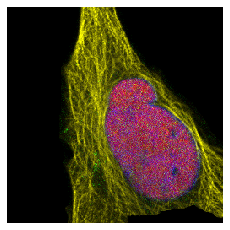

In [5]:
print(dataset[0].shape)
dataset.set_channel_colors(COLOR_MAP)
dataset.view(0)
# image_viewer.view(dataset[0])

100%|██████████| 74/74 [00:01<00:00, 60.92it/s]


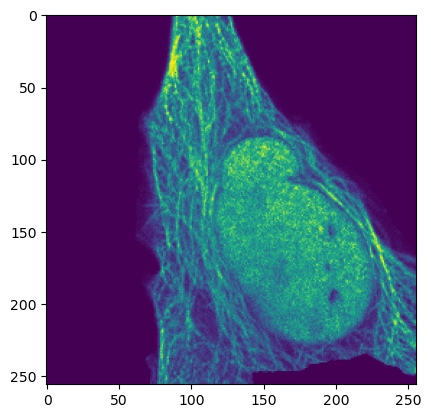

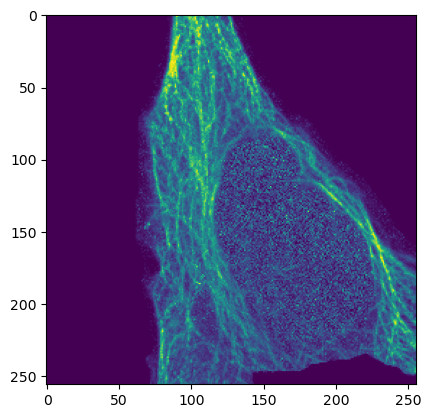

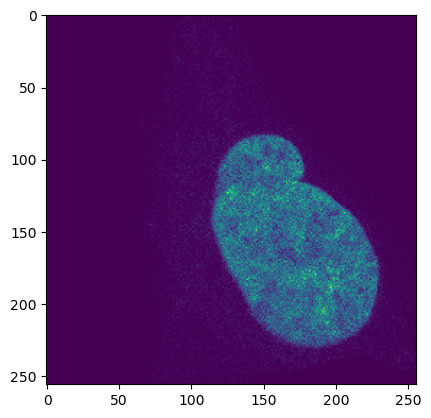

1it [00:00,  8.74it/s]

[PosixPath('/home/ishang/HPA-embedding/dev-dataset-FUCCI/rgb_dataset-0.pt')]


In [6]:
rgb_dataset = dataset.as_rgb(num_workers=128)
for i in range(rgb_dataset[0].shape[0]):
    plt.imshow(rgb_dataset[0][i, :, :].numpy())
    plt.show()
rgb_dataset.save(DATA_DIR / "rgb_dataset.pt")
rgb_dataset = SimpleDataset(path=(DATA_DIR / "rgb_dataset.pt"))

In [7]:
dinov2_vitl14.to(device)

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [8]:
batch_size = 1
embeddings = []
with torch.no_grad():
    for i in range(0, len(rgb_dataset), batch_size):
        embedding = dinov2_vitl14(rgb_dataset[i:i+batch_size, :, 2:-2, 2:-2].to(device))
        embeddings.append(embedding)
embeddings = torch.cat(embeddings)
print(embeddings.shape)

torch.Size([74, 1024])


In [9]:
embeddings = embeddings.cpu().numpy()

<Axes: >

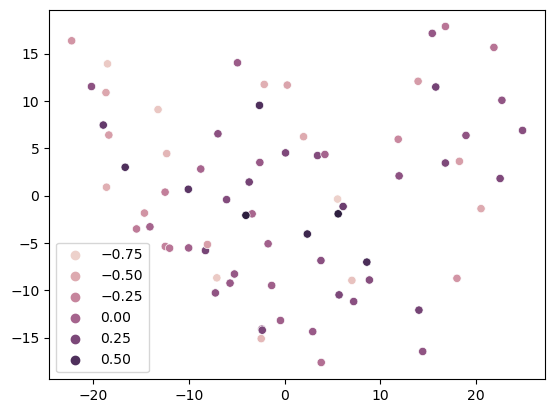

In [10]:
# do PCA on the embeddings
from sklearn.decomposition import PCA
import seaborn as sns

num_plot = 1000
pca = PCA(n_components=2)
pca.fit(embeddings[:num_plot])
embeddings_pca = pca.transform(embeddings[:num_plot])

intensities = dataset[:num_plot].sum(dim=(2, 3))
colors = (intensities[:, 2] - intensities[:, 3]) / (intensities[:, 2] + intensities[:, 3])
colors = colors.cpu().numpy()
sns.scatterplot(x=embeddings_pca[:, 0], y=embeddings_pca[:, 1], hue=colors)

In [11]:
# show PCA colors on image patches
# but first add the pseudotime calculation for the dataset and train a classifier to predict pseudotime from dino embeddings